In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
from src.datapipeline import Datapipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from src.ml_model import ForecastModel

import seaborn as sns
import matplotlib.pyplot as plt

## Data Cleaning and Feature Engineering

Based on the EDA, we see that

1. There is some helpful insights from introducing some lag features due to autocorrelation
1. There were some missing rows which need to be filled. 
1. We will need to perform one-hot encoding for the cardinal directions

All are done within src/datapipeline.py

In [ ]:
datapipeline_obj = Datapipeline()
df = datapipeline_obj.run_data_pipeline()

In [ ]:
df.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,DEWP_ma3,TEMP_ma3,PRES_ma3,Iws_ma3,cbwd_NE,cbwd_SE,cbwd_cv,lag1,lag2,lag3
datetime,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,129.0,-21,-11.0,1021.0,1.79,0,0,-21.000000,-11.333333,1020.000000,4.473333,False,False,False,NaN,NaN,NaN
2010-01-01 01:00:00,129.0,-21,-12.0,1020.0,4.92,0,0,-21.000000,-11.333333,1020.000000,4.473333,False,False,False,NaN,NaN,NaN
2010-01-01 02:00:00,129.0,-21,-11.0,1019.0,6.71,0,0,-21.000000,-11.333333,1020.000000,4.473333,False,False,False,NaN,NaN,NaN
2010-01-01 03:00:00,129.0,-21,-14.0,1019.0,9.84,0,0,-21.000000,-12.333333,1019.333333,7.156667,False,False,False,NaN,NaN,NaN
2010-01-01 04:00:00,129.0,-20,-12.0,1018.0,12.97,0,0,-20.666667,-12.333333,1018.666667,9.840000,False,False,False,NaN,NaN,NaN


## Time Series Cross Validation Split



In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*180*1, gap=24)
df = df.sort_index()

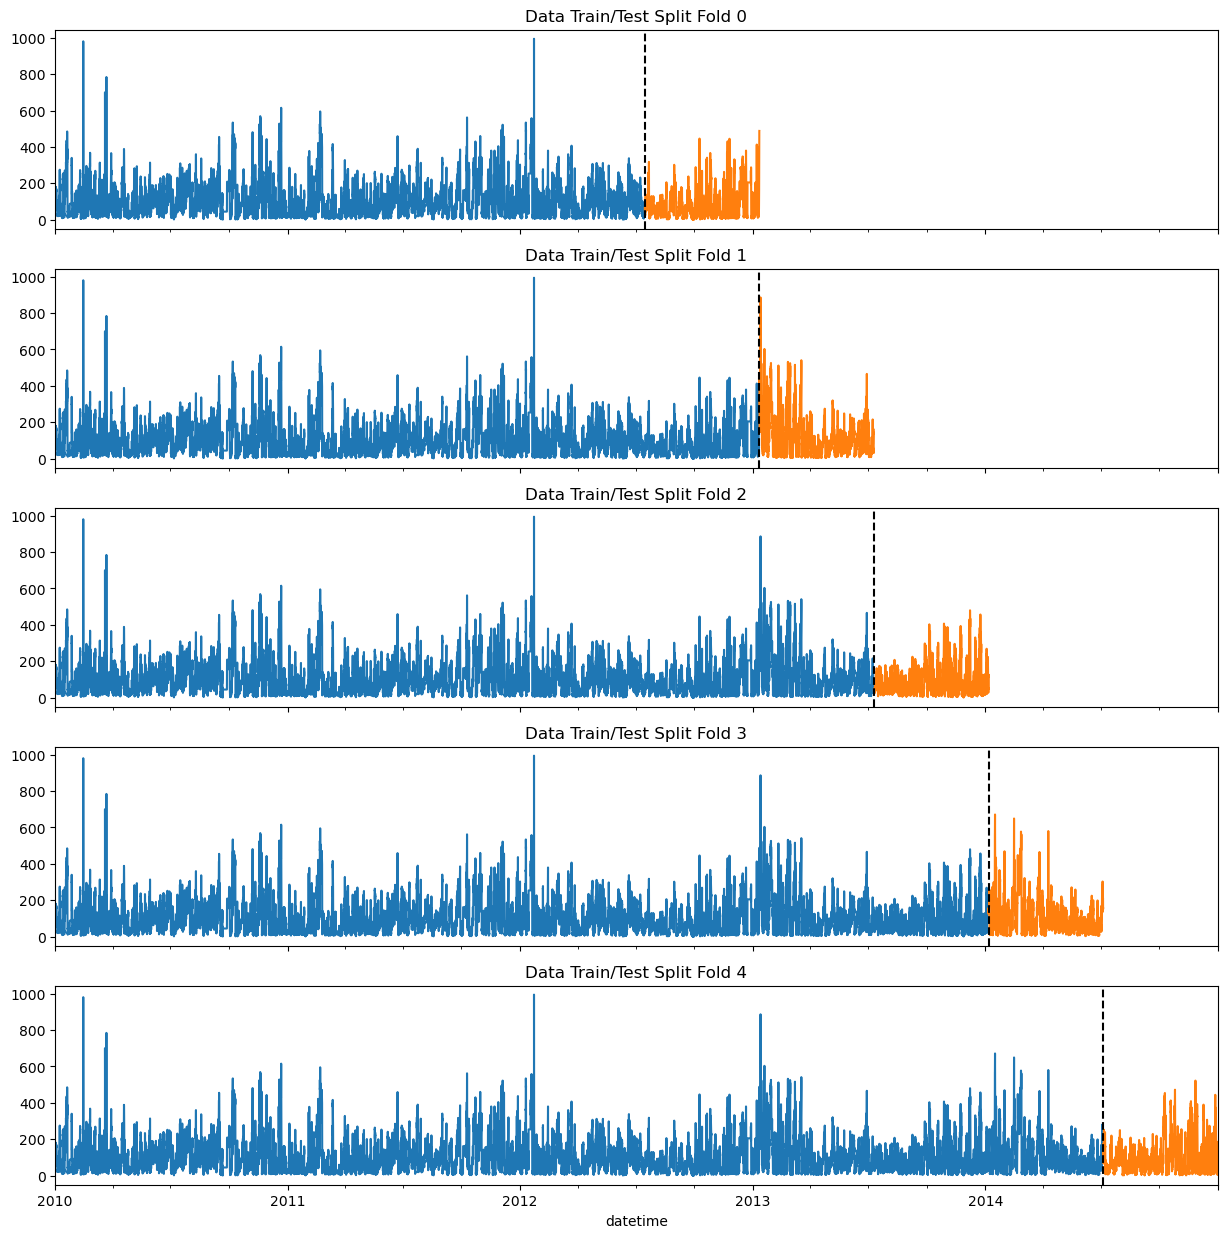

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['pm2.5'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['pm2.5'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [ ]:
## Training the Model and Evaluation

We train the model on the k-fold split data. The model chosen was RandomForestRegressor. 

Based on the evaluation, we see that the Train MSE hovers around 300 - 400. However, the Test MSE is 5000 - 7000. 

Fold 1
Train MSE: 338.6242828063064, Test MSE: 7108.583193171296
Fold 2
Train MSE: 350.9956108748115, Test MSE: 8022.013857453704
Fold 3
Train MSE: 392.5672438618677, Test MSE: 4680.013375856482
Fold 4
Train MSE: 392.41233454493744, Test MSE: 6917.855882175925
Fold 5
Train MSE: 409.98919262664646, Test MSE: 5499.664885416667


In [ ]:
## Forecasting

We first train the model on the full set, we then do impute the dataset for forecasting. The method is to aggregate the values based on past three years data. 



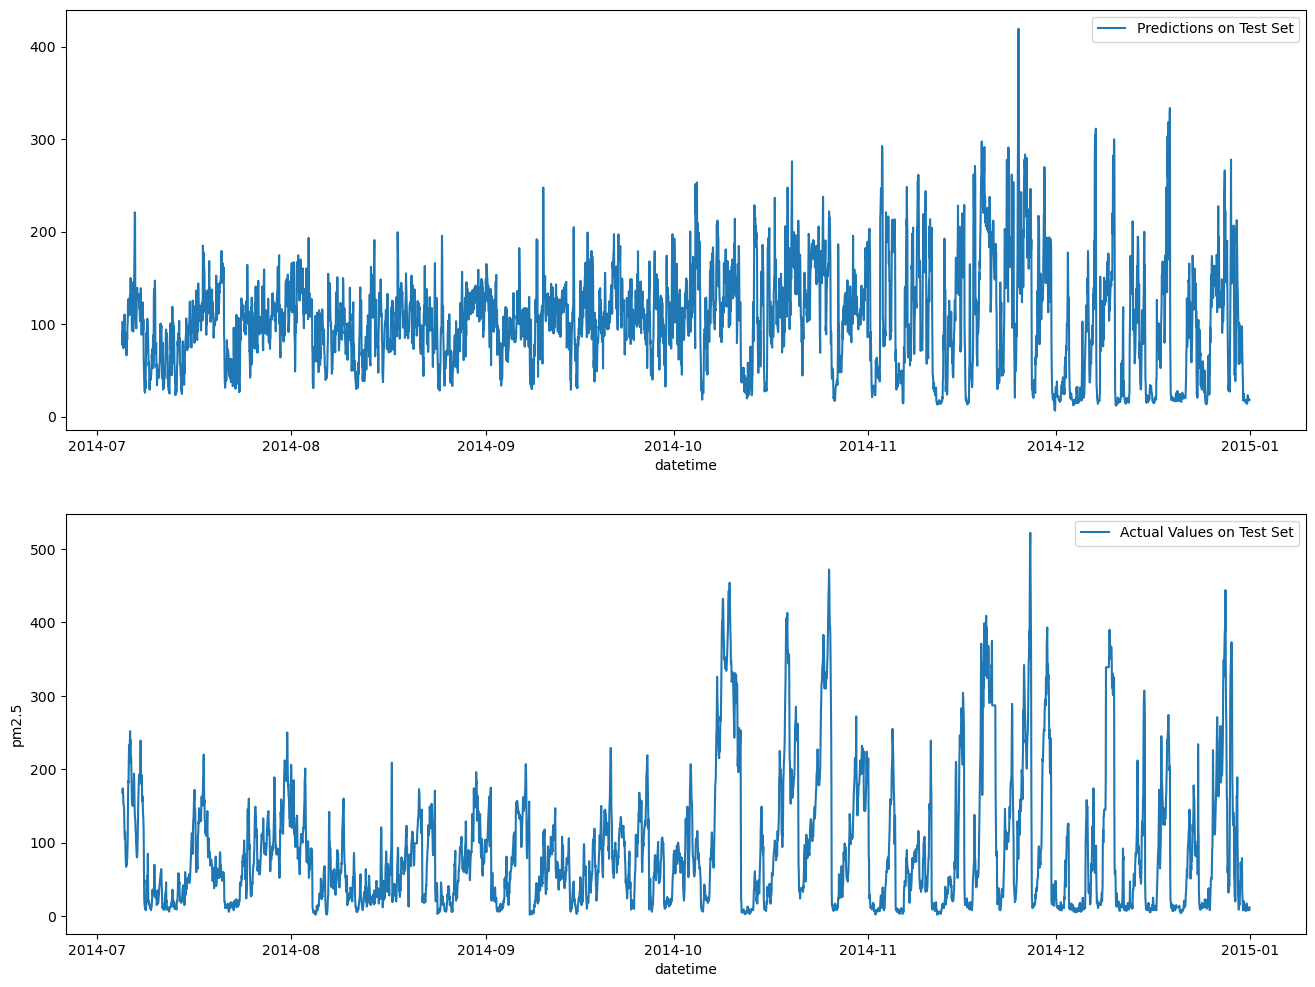

In [ ]:
preds = model.predict(X_test)

# subplot lineplots
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

sns.lineplot(x=test.index, y=preds, ax=axes[0], label ='Predictions on Test Set')
sns.lineplot(x=test.index, y=y_test, ax=axes[1], label ='Actual Values on Test Set')
plt.show()

In [ ]:
# we want to, based on the past values of each covariate, create lag features for forecasting
# these features will be the aggregate of the past 3 years of the same day and hour

# def create_covariate_features(df, covariate_cols, lag):
#     for col in covariate_cols:
#         target_map = df[col].to_dict()
#         df[col] = (df.index - pd.Timedelta(f'{lag} days')).map(target_map)
#     return df

def impute_by_past_years_fast(df, cols, years=3):
    df = df.copy()
    df['month_day_hour'] = df.index.strftime('%m-%d %H:%M')
    
    for col in cols:
        yearly_mean = (
            df.groupby('month_day_hour')[col]
              .transform(lambda x: x.rolling(years, min_periods=1).mean())
        )
        df[col] = df[col].fillna(yearly_mean)
    
    df = df.drop(columns=['month_day_hour'])
    return df


# we next need a function for forecasting horizon
# we will forecast 1 hour ahead for the next six months
future = pd.date_range('2015-01-01','2015-01-08', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
covariate_cols = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'DEWP_ma3', 'TEMP_ma3', 'PRES_ma3', 'Iws_ma3', 'cbwd_NE', 'cbwd_SE', 'cbwd_cv']
df_and_future = impute_by_past_years_fast(df_and_future, covariate_cols, years = 3)
df_and_future = add_lags(df_and_future)

In [ ]:
future_w_features = df_and_future.query('isFuture').copy()

In [ ]:
future_w_features.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,DEWP_ma3,TEMP_ma3,PRES_ma3,Iws_ma3,cbwd_NE,cbwd_SE,cbwd_cv,lag1,lag2,lag3,isFuture
2015-01-01 00:00:00,NaN,-15.0,1.0,1016.0,74.645,0.0,0.0,-15.500000,0.166667,1016.000000,70.026667,0.0,0.0,0.0,20.0,180.0,18.0,True
2015-01-01 01:00:00,NaN,-15.5,0.0,1015.0,78.665,0.0,0.0,-15.166667,0.500000,1015.666667,74.346667,0.0,0.0,0.0,22.0,170.0,20.0,True
2015-01-01 02:00:00,NaN,-15.5,-0.5,1015.0,81.570,0.0,0.0,-15.333333,0.166667,1015.333333,78.293333,0.0,0.0,0.0,22.0,160.0,17.0,True
2015-01-01 03:00:00,NaN,-17.0,-2.0,1015.5,84.030,0.0,0.0,-16.000000,-0.833333,1015.166667,81.421667,0.0,0.0,0.0,10.0,146.0,9.0,True
2015-01-01 04:00:00,NaN,-16.5,-3.5,1015.0,0.670,0.0,0.0,-16.333333,-2.000000,1015.166667,55.423333,0.0,0.0,1.0,14.0,125.0,16.0,True


In [ ]:
predictions = full_model.predict(future_w_features.drop(columns=['pm2.5', 'isFuture']))

In [ ]:
future = pd.date_range('2015-01-01','2015-01-08', freq='1h')
predictions = pd.Series(predictions, index=future)

In [ ]:
df['pm2.5']

datetime
2010-01-01 00:00:00    129.0
2010-01-01 01:00:00    129.0
2010-01-01 02:00:00    129.0
2010-01-01 03:00:00    129.0
2010-01-01 04:00:00    129.0
                       ...  
2014-12-31 19:00:00      8.0
2014-12-31 20:00:00     10.0
2014-12-31 21:00:00     10.0
2014-12-31 22:00:00      8.0
2014-12-31 23:00:00     12.0
Name: pm2.5, Length: 43824, dtype: float64

<Axes: title={'center': 'PM2.5 Actual and Forecast'}, xlabel='datetime'>

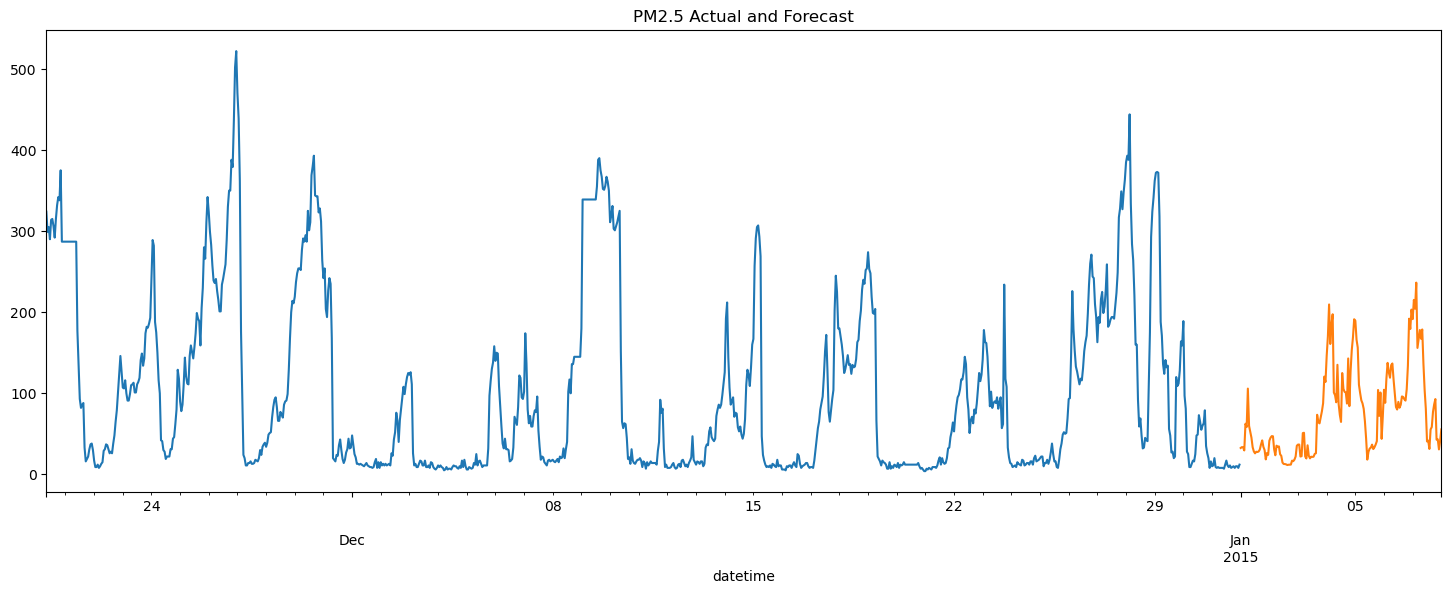

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(18,6))
df['pm2.5'].iloc[-1000:].plot(ax=ax,
                label='PM2.5',
                title=f'PM2.5 Actual and Forecast')
predictions.plot(ax=ax,
                label='PM2.5 Forecast')

## Conclusion


The forecasting workflow demonstrates the ability to predict PM2.5 levels using historical and engineered features. The model performs well on training data but struggles to generalize, as seen by higher test errors. This suggests the need for further refinement.

**Suggestions for improvement:**
- Test additional models, such as XGBoost or LSTM, to better capture non-linear and temporal dependencies.
- Add more external data sources (e.g., weather, holidays, traffic) to improve feature richness.
- Enhance feature engineering, especially with lagged and rolling statistics, to leverage time series structure.
- Use cross-validation and grid search for hyperparameter tuning and regularization.
- Analyze residuals and error patterns to identify systematic issues or missing information.

Continued experimentation and feature expansion will help build a more robust and accurate air quality forecasting solution.